## Env Creative

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v2

## Function to add Gaussian noise to the image

In [2]:
def add_noise(img, noise_level):
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

## Define the DIP model (Assuming a simple CNN architecture)

In [3]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

## Define Show Image Function

## Load target image

In [4]:
img_path = '/kaggle/input/lenna-test-image/Lenna_(test_image).png'
target_img = imageio.imread(img_path)

if target_img.dtype == np.uint8:
    target_img = target_img / 255.0

/tmp/ipykernel_24/1330099834.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  target_img = imageio.imread(img_path)


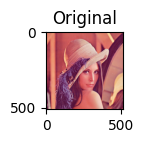

In [5]:
plt.figure(figsize=(3, 1))
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.show()

## Define noise levels and stages

In [6]:
noise_level = 0.1
noisy_img = add_noise(target_img, noise_level)

## Prepare for Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
noisy_img_torch = torch.tensor(noisy_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
target_img_torch = torch.tensor(target_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

In [9]:
model = DIPModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Training

In [10]:
num_epochs = 3000
patience = 50
best_psnr = 0
best_model = None
psnr_history = []

no_improvement_count = 0  # Initialize the no improvement counter

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch [0/3000], Loss: 0.2983, PSNR: 5.3248, SSIM: 0.0465


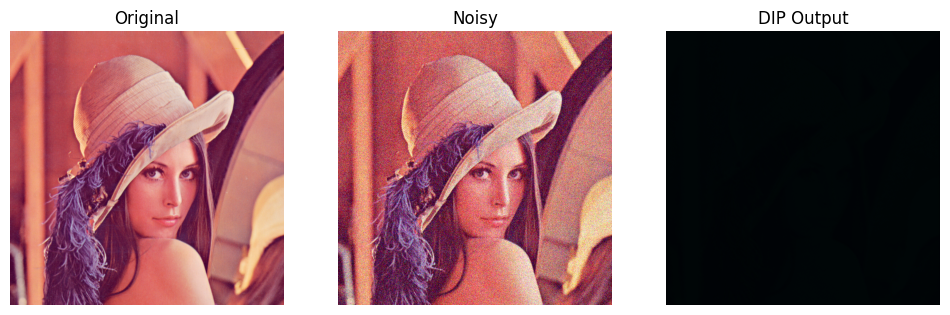

 33%|███▎      | 991/3000 [03:16<06:45,  4.96it/s]

Epoch [1000/3000], Loss: 0.0023, PSNR: 26.3403, SSIM: 0.7558


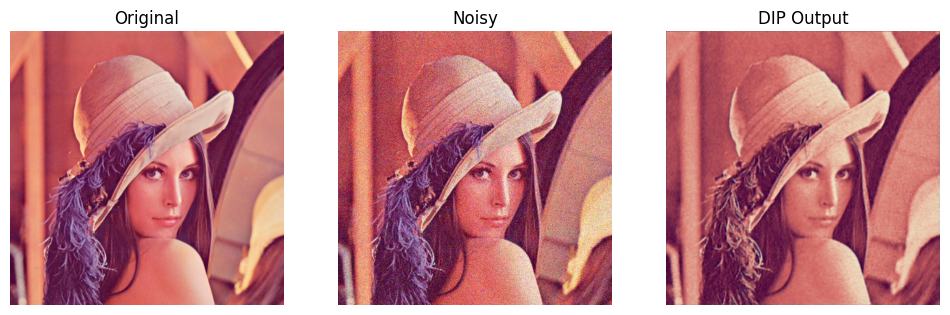

 46%|████▌     | 1380/3000 [04:35<05:23,  5.01it/s]

Early stopping at epoch 1380


In [11]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    output = model(noisy_img_torch)
    loss = criterion(output, target_img_torch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            output_img = output.squeeze().cpu().numpy().transpose(1, 2, 0)
            output_img = np.clip(output_img, 0, 1)
            current_psnr = psnr(target_img, output_img, data_range=1.0)
            current_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)
            psnr_history.append(current_psnr)
            # print(f"Epoch: {epoch}, PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}")

            # Check for early stopping
            if current_psnr - best_psnr >= 0.001:
                best_psnr = current_psnr
                best_model = model.state_dict()
                # no_improvement_count = 0  # Reset counter if improvement
            else:
                no_improvement_count += 1                

            if no_improvement_count >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
                        # Plot and save the current output image
            if epoch % 1000 == 0 or epoch == num_epochs - 1:
                print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}')
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 3, 1)
                plt.title("Original")
                plt.imshow(np.clip(target_img, 0, 1))  
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.title("Noisy")
                plt.imshow(np.clip(noisy_img, 0, 1)) 
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.title("DIP Output")
                plt.imshow(output_img)
                plt.axis('off')
                plt.show()

In [12]:
model.load_state_dict(best_model)

<All keys matched successfully>

## Evaluation

In [13]:
model.eval()
with torch.no_grad():
    final_output = model(noisy_img_torch).squeeze().cpu().numpy().transpose(1, 2, 0)
    final_output = np.clip(final_output, 0, 1)
    final_psnr = psnr(target_img, final_output, data_range=1.0)
    final_ssim = ssim(target_img, final_output, data_range=1.0, channel_axis=-1)
    print(f"Final PSNR: {final_psnr:.4f}, Final SSIM: {final_ssim:.4f}")

Final PSNR: 25.9803, Final SSIM: 0.7432


## Visulize the result

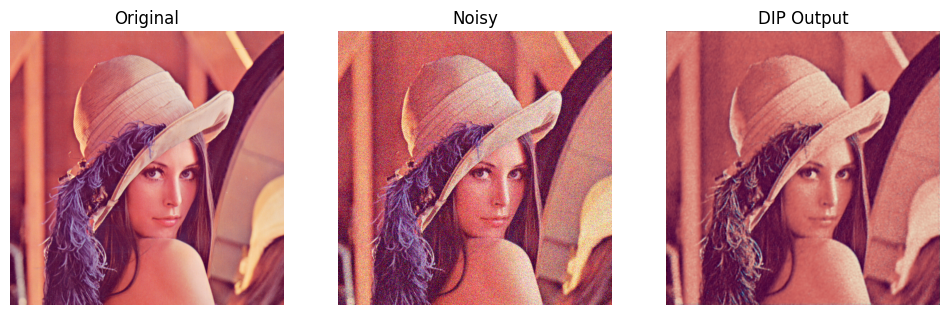

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Noisy")
plt.imshow(np.clip(noisy_img, 0, 1))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("DIP Output")
plt.imshow(final_output)
plt.axis('off')
plt.show()